In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import time
from tensorflow.python.layers.base import Layer

In [2]:
import nodule_util
# mnist = input_data.read_data_sets("mnist/")
nodule = nodule_util.read_data_sets("nodule/")
print(nodule.train.images.shape)
print(nodule.validation.images.shape)
print(nodule.test.images.shape)
# num_train=mnist.train.num_examples
# num_val=mnist.validation.num_examples
# num_test=mnist.test.num_examples
num_train = nodule.train.num_examples
num_val = nodule.validation.num_examples
num_test = nodule.test.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting nodule/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting nodule/train-labels-idx1-ubyte.gz
Extracting nodule/t10k-images-idx3-ubyte.gz
Extracting nodule/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(3000, 1024)
(700, 1024)
(409, 1024)


In [3]:
transform_mean = np.ones(1024)*0.5
transform_std = np.ones(1024)*0.5

In [4]:
width = 32
height = 32
channel = 1
Gaussian_scale = 1.0
learning_label = 5

In [5]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,height*width*channel],name='input_image')
y=tf.placeholder(dtype=tf.int32,shape=[None])

mask_psed_neg=tf.reshape(tf.cast(tf.equal(y,1),tf.float32),(-1,1))
mask_not_psed_neg=tf.reshape(tf.cast(tf.logical_not(tf.equal(y,1)),tf.float32),(-1,1))

y_onehot=tf.one_hot(y,3)

class CNN_bn_Classifier(Layer):
    def __init__(self):
        self.conv1=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv1',_reuse=tf.AUTO_REUSE)
        self.conv2=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv2',_reuse=tf.AUTO_REUSE)
        self.conv3=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv3',_reuse=tf.AUTO_REUSE)
        self.batch_norm1=tf.layers.BatchNormalization(axis=3,name='bn1',_reuse=tf.AUTO_REUSE)
        self.batch_norm2=tf.layers.BatchNormalization(axis=3,name='bn2',_reuse=tf.AUTO_REUSE)
        self.batch_norm3=tf.layers.BatchNormalization(axis=3,name='bn3',_reuse=tf.AUTO_REUSE)
        self.max_pool=tf.layers.MaxPooling2D(pool_size=2,strides=2,_reuse=tf.AUTO_REUSE)
        self.fc=tf.layers.Dense(units=3,_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs,is_training):
        out1=self.max_pool(self.batch_norm1(self.conv1(inputs),training=is_training))
        out2=self.max_pool(self.batch_norm2(self.conv2(out1),training=is_training))
        out3=self.max_pool(self.batch_norm3(self.conv3(out2),training=is_training))
        score=self.fc(tf.layers.flatten(out3))
        return score
    
class CNN_Classifier(Layer):
    def __init__(self):
        self.conv1=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv1',_reuse=tf.AUTO_REUSE)
        self.conv2=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv2',_reuse=tf.AUTO_REUSE)
        self.conv3=tf.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation=tf.nn.relu,name='conv3',_reuse=tf.AUTO_REUSE)
        self.max_pool=tf.layers.MaxPooling2D(pool_size=2,strides=2,_reuse=tf.AUTO_REUSE)
        self.avg_pool=tf.layers.AveragePooling2D(pool_size=7,strides=7,_reuse=tf.AUTO_REUSE)
        self.fc=tf.layers.Dense(units=3,_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs):
        out1=self.max_pool(self.conv1(inputs))
        out2=self.max_pool(self.conv2(out1))
        out3=self.avg_pool(self.conv3(out2))
        score=self.fc(tf.layers.flatten(out3))
        return score
    
class NN_Classifier(Layer):
    def __init__(self):
        self.linear1=tf.layers.Dense(units=512,name='linear1',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear2=tf.layers.Dense(units=256,name='linear2',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear3=tf.layers.Dense(units=256,name='linear3',activation=tf.nn.relu,_reuse=tf.AUTO_REUSE)
        self.linear4=tf.layers.Dense(units=3,name='linear4',_reuse=tf.AUTO_REUSE)
    
    def __call__(self,inputs):
        score=self.linear4(self.linear3(self.linear2(self.linear1(inputs))))
        return score    

# emit_initializer=tf.initializers.random_normal(mean=0.0,stddev=0.15)
    
class VAE(Layer):
    def __init__(self):
        self.lstm_hidden_dim=256
        self.latent_dim=512
        self.n_time=15
#         self.encoder_lstm=tf.contrib.rnn.LSTMCell(self.lstm_hidden_dim)
#         self.decoder_lstm=tf.contrib.rnn.LSTMCell(self.lstm_hidden_dim)
        self.encoder_lstm=tf.contrib.rnn.GRUCell(self.lstm_hidden_dim)
        self.decoder_lstm=tf.contrib.rnn.GRUCell(self.lstm_hidden_dim)
        self.encode_mean=tf.layers.Dense(units=self.latent_dim,name='encode_mean')   # calculate mean of z
        self.encode_std=tf.layers.Dense(units=self.latent_dim,name='encode_std')   # calculate std of z
        self.unit_gaussian=tf.distributions.Normal(loc=tf.zeros(self.latent_dim),scale=Gaussian_scale*tf.ones(self.latent_dim))
#         self.emit_net=tf.layers.Dense(units=height*width*channel,name='emit_net',kernel_initializer=emit_initializer)
        self.emit_net=tf.layers.Dense(units=height*width*channel,name='emit_net')
        
        
    def __call__(self,inputs):
        batch_size=tf.shape(inputs)[0]
        state_encode=self.encoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
        state_decode=self.decoder_lstm.zero_state(batch_size, tf.float32)   # lstm tuple (c,h)
        original_image=tf.layers.flatten(inputs)
        output_image=None
        latent_loss_his=[]
        classifier_loss_his=[]
        likelihood_his=[]
        predict_his=[]
        image_his=[]
        
        for t in range(self.n_time):
            if t==0:
                image=original_image
            else:
                # use output_image for fake images, use original image for real image
                image=mask_psed_neg*output_image+mask_not_psed_neg*original_image
            image_his.append(image)
            '''
            Part I: Classifier
            '''
            classifier_scope="CNN_classifier_"+str(t)
#             input_image=tf.reshape(image,(-1,height,width,channel))
            input_image=tf.reshape(image,(-1,height*width*channel))
            with tf.variable_scope(classifier_scope) as vs:
#                 classifier=CNN_Classifier()
#                 score_likelihood=classifier(input_image)
                classifier=NN_Classifier()
                score_likelihood=classifier(input_image)
            with tf.variable_scope(classifier_scope) as vs:
#                 classifier=CNN_Classifier()
#                 score_classifier=classifier(tf.stop_gradient(input_image))
                classifier=NN_Classifier()
                score_classifier=classifier(tf.stop_gradient(input_image))
            
            score_likelihood=tf.reshape(score_likelihood[:,0]-score_likelihood[:,1],(-1,1))*mask_psed_neg
            likelihood_his.append(score_likelihood) # only record score for fake images
            classifier_loss_his.append(tf.losses.softmax_cross_entropy(logits=score_classifier,onehot_labels=y_onehot))
            predict_his.append(score_classifier)
            
            '''
            Part II: Recurrent VAE
            '''
            # add noise
            image+=tf.random_normal(shape=tf.shape(image),mean=0.0,stddev=1.0)
#             image=tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)
            with tf.variable_scope("pre_encoder") as vs:
                image=tf.layers.dense(image,units=512,activation=tf.nn.relu,name='dense_preencoder',reuse=tf.AUTO_REUSE)
            with tf.variable_scope("LSTM_encoder") as vs:
                encode_out,state_encode=self.encoder_lstm(image,state_encode)
            z_mean=self.encode_mean(encode_out)
            z_std=tf.exp(self.encode_std(encode_out))
            distrib_encode=tf.distributions.Normal(loc=z_mean,scale=z_std)
            Z=distrib_encode.sample()
            
            latent_loss=tf.reduce_sum(mask_psed_neg*tf.distributions.kl_divergence(distrib_encode,self.unit_gaussian),axis=1)
            latent_loss_his.append(latent_loss)
            
            with tf.variable_scope("LSTM_decoder") as vs:
                decode_out,state_decode=self.decoder_lstm(Z,state_decode)
                
            output_image=self.emit_net(decode_out)
            
        tot_latent_loss=tf.reduce_mean(latent_loss_his)
        tot_classifier_loss=tf.reduce_mean(classifier_loss_his)
        tot_likelihood_loss=tf.reduce_sum(likelihood_his,axis=0)  # accumulate score through time
        tot_likelihood_loss=tf.reduce_mean(-tot_likelihood_loss)
        
        tot_loss=tot_latent_loss+tot_classifier_loss+tot_likelihood_loss
            
        return image_his,tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss,predict_his


vae=VAE()
image_his,tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss,predict_his=vae(X)
tot_classifier_loss=tot_classifier_loss
tot_loss2=tot_latent_loss+tot_likelihood_loss

classifier_variables=[]
vae_variables=[]
for v in tf.global_variables():
    if v.name.find('CNN_classifier')!=-1:
        classifier_variables.append(v)
    else:
        vae_variables.append(v)


global_step1 = tf.Variable(0, trainable=False)
starter_learning_rate1 = 1e-3
learning_rate1 = tf.train.exponential_decay(starter_learning_rate1, global_step1,300, 0.98, staircase=True)
optimizier1=tf.train.AdamOptimizer(learning_rate=learning_rate1)
train_step1 = optimizier1.minimize(tot_classifier_loss,global_step=global_step1,var_list=classifier_variables)

global_step2 = tf.Variable(0, trainable=False)
starter_learning_rate2 = 4e-4
learning_rate2 = tf.train.exponential_decay(starter_learning_rate2, global_step2,100, 0.98, staircase=True)
optimizier2=tf.train.RMSPropOptimizer(learning_rate=learning_rate2)
train_step2 = optimizier2.minimize(tot_loss2,var_list=vae_variables)
# train_step2 = optimizier2.minimize(tot_loss2,global_step=global_step2,var_list=vae_variables)

# optimizier3=tf.train.AdamOptimizer(learning_rate=1e-3)
# train_step3 = optimizier3.minimize(tot_loss)

# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use keras

In [6]:
# Generate process
G_batch_size=tf.placeholder(shape=(),dtype=tf.int32,name='batch_size')
G_state_decode=vae.decoder_lstm.zero_state(G_batch_size, tf.float32)
G_unit_gaussian=tf.distributions.Normal(loc=tf.zeros((G_batch_size,vae.latent_dim)),scale=Gaussian_scale*tf.ones((G_batch_size,vae.latent_dim)))

G_output_his=[]

for t in range(vae.n_time):
    G_Z=G_unit_gaussian.sample()
    with tf.variable_scope("LSTM_decoder") as vs:
        G_decode_out,G_state_decode=vae.decoder_lstm(G_Z,G_state_decode)
    G_output_image=vae.emit_net(G_decode_out)
    G_output_his.append(G_output_image)
G_output_result=G_output_his[-2]  # last output images is meaningless(no gradient on this image)

In [7]:
def display():
    output_images=sess.run(G_output_result,feed_dict={G_batch_size:9})  # (9,784)
#     output_images=output_images*0.5+0.5
#     output_images=(output_images+0.3)/0.6
    output_images=output_images+0.5
    
    plt.figure(figsize = (3,3))
    gs1 = gridspec.GridSpec(3,3)
    gs1.update(wspace=0.025, hspace=0.05)

    for i in range(9):
        plt.subplot(gs1[i])
        plt.imshow(output_images[i,:].reshape(32,32))
        plt.axis('off')
#     plt.savefig('a.png')
    plt.show()

In [10]:
def make_batch(batch_size,fake_size,noise_size):
    X_true,labels=nodule.train.next_batch(batch_size)
    index=np.where(labels==learning_label)[0]
    X_true=X_true[index,:]
#     X_true=X_true*2-1  # range=(-1,1)
#     X_true=X_true*0.6-0.3  # range=(-0.3,0.3)
    X_true=X_true-0.5  # range=(-0.5,0.5)
    X_fake=np.random.uniform(low=-1.5,high=1.5,size=(fake_size,height*width*channel))
    X_noise=np.random.uniform(low=-1.5,high=1.5,size=(noise_size,height*width*channel))
#     X_fake=np.random.normal(loc=0.0,scale=5.0,size=(fake_size,height*width*channel))
#     X_noise=np.random.normal(loc=0.0,scale=5.0,size=(noise_size,height*width*channel))
    image=np.vstack((X_true,X_fake,X_noise))
    label=np.concatenate((np.zeros(X_true.shape[0]),np.ones(fake_size),2*np.ones(noise_size)))
    return image,label,X_true.shape[0]

2020-12-01 16:49:38 iteration 1/1000: current training loss = 11.923803 (=10.520566+1.171706+0.231531)


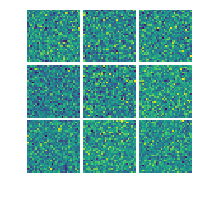

In [ ]:
batch_size=640
fake_size=128
noise_size=512
num_iteration=1000
print_every=100
test_every=100


classifier_train=3
vae_train=1

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for it in range(num_iteration):
        image,label,true_num=make_batch(batch_size,fake_size,noise_size)
#         image,label=make_batch_new(batch_size,fake_size)
        feed_dict={X:image,y:label}
        loss_num,l1,l2,l3=sess.run([tot_loss,tot_latent_loss,tot_classifier_loss,tot_likelihood_loss],feed_dict=feed_dict)
        for t in range(classifier_train):
#             _,__=sess.run([train_step1,extra_update_ops],feed_dict={X:image,y:label})
            _=sess.run([train_step1],feed_dict={X:image,y:label})
        for t in range(vae_train):
            _=sess.run([train_step2],feed_dict={X:image,y:label})
        
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f (=%f+%f+%f)' % (loss_num,l1,l2,l3))
        
        if it==0 or (it+1)%test_every==0 or it==num_iteration-1:
            display()